# Twitter_CyberBully_Classification_Word2Vec

### Description: This dataset is a collection of datasets from different sources related to the automatic detection of cyber-bullying. The data is from different social media platforms like Kaggle, Twitter, Wikipedia Talk pages, and YouTube. The data contains text and are labeled as bullying or not. The data contains different types of cyber-bullying like hate speech, aggression, insults, and toxicity. You have been provided with the twitter_parsed tweets dataset, wherein you have to classify whether the tweet is toxic or not.

#from google.colab import drive
#drive.mount('/gdrive')

#import os
#ROOT = "/content/drive/MyDrive/NLP/Text_Classification"
#os.chdir(ROOT)

In [852]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,RegexpTokenizer,sent_tokenize
from textblob import TextBlob
from wordcloud import WordCloud

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from gensim.models import word2vec

import pickle
from tqdm import tqdm
from collections import Counter

from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score,f1_score,precision_score,precision_recall_fscore_support,confusion_matrix


In [348]:
df = pd.read_csv("data/twitter_parsed_dataset.csv")

In [349]:
df.head(10)

index                     id  \
0  5.74948705591165E+017  5.74948705591165E+017   
1  5.71917888690393E+017  5.71917888690393E+017   
2  3.90255841338601E+017  3.90255841338601E+017   
3  5.68208850655916E+017  5.68208850655916E+017   
4  5.75596338802373E+017  5.75596338802373E+017   
5  5.61184804004041E+017  5.61184804004041E+017   
6  4.36563082093949E+017  4.36563082093949E+017   
7  5.75962326454641E+017  5.75962326454641E+017   
8  5.72581510248706E+017  5.72581510248706E+017   
9  5.00456367719989E+017  5.00456367719989E+017   

                                                Text Annotation  oh_label  
0  @halalflaws @biebervalue @greenlinerzjm I read...       none       0.0  
1  @ShreyaBafna3 Now you idiots claim that people...       none       0.0  
2  RT @Mooseoftorment Call me sexist, but when I ...     sexism       1.0  
3  @g0ssipsquirrelx Wrong, ISIS follows the examp...     racism       1.0  
4                             #mkr No No No No No No       none       0.0  
5  RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...       none       0.0  
6  RT @Millhouse66 @Maureen_JS nooo not sexist bu...     sexism       1.0  
7  Going to make some pancakes.....Don't hve any ...       none       0.0  
8  RT @ahtweet: @freebsdgirl How dare you have fe...       none       0.0  
9  RT @Newmanzaa: There's something wrong when a ...     sexism       1.0

In [350]:
df.shape

(16851, 5)

We are interested in twits and labels

In [351]:
## explore some rows data

df.loc[13,"Text"]

"@scamp_faridxx @AbuAlbaraaSham Yeah, it's called caring about human life, idiot - something a genocidal Daesh would'nt understand."

In [265]:
df.loc[13,"oh_label"]

1.0

In [266]:
df['Text'].sample(1).values[0]

'@Murderblonde YES'

### lets see the distribution of the class

<AxesSubplot:xlabel='oh_label', ylabel='count'>

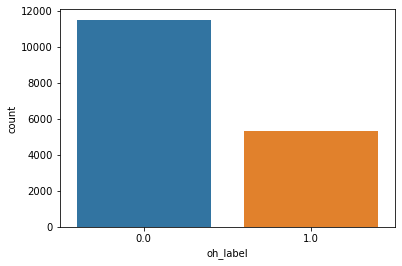

In [267]:
sns.countplot(x="oh_label",data=df)

In [268]:
df['oh_label'].value_counts()

0.0    11501
1.0     5347
Name: oh_label, dtype: int64

In [269]:
## lets check the % of data
5347/(11501+5347)

0.3173670465337132

### 30% data is in class 1, its not a very skwed data.

### Find the lengh of Text and see the sentiment

In [352]:
df['Text_len']= df['Text'].apply(lambda x: len(str(x)))

In [271]:
df

index                     id  \
0      5.74948705591165E+017  5.74948705591165E+017   
1      5.71917888690393E+017  5.71917888690393E+017   
2      3.90255841338601E+017  3.90255841338601E+017   
3      5.68208850655916E+017  5.68208850655916E+017   
4      5.75596338802373E+017  5.75596338802373E+017   
...                      ...                    ...   
16846  5.75606766236475E+017  5.75606766236475E+017   
16847  5.72333822886326E+017  5.72333822886326E+017   
16848  5.72326950057845E+017  5.72326950057845E+017   
16849  5.74799612642357E+017  5.74799612642357E+017   
16850  5.68826121153684E+017  5.68826121153684E+017   

                                                    Text Annotation  oh_label  \
0      @halalflaws @biebervalue @greenlinerzjm I read...       none       0.0   
1      @ShreyaBafna3 Now you idiots claim that people...       none       0.0   
2      RT @Mooseoftorment Call me sexist, but when I ...     sexism       1.0   
3      @g0ssipsquirrelx Wrong, ISIS follows the examp...     racism       1.0   
4                                 #mkr No No No No No No       none       0.0   
...                                                  ...        ...       ...   
16846  Feeling so sorry for the girls, they should be...       none       0.0   
16847  #MKR 'pretty good dishes we're happy with' - O...       none       0.0   
16848  RT @colonelkickhead: Deconstructed lemon tart!...       none       0.0   
16849  @versacezaynx @nyazpolitics @greenlinerzjm You...       none       0.0   
16850  And before you protest that you're *not* mad, ...       none       0.0   

       Text_len  
0           140  
1           140  
2            91  
3            83  
4            22  
...         ...  
16846        95  
16847        85  
16848       140  
16849        82  
16850       134  

[16851 rows x 6 columns]

In [353]:
df.drop(columns=['index','id','Annotation'],inplace=True)

In [354]:
df

Text  oh_label  Text_len
0      @halalflaws @biebervalue @greenlinerzjm I read...       0.0       140
1      @ShreyaBafna3 Now you idiots claim that people...       0.0       140
2      RT @Mooseoftorment Call me sexist, but when I ...       1.0        91
3      @g0ssipsquirrelx Wrong, ISIS follows the examp...       1.0        83
4                                 #mkr No No No No No No       0.0        22
...                                                  ...       ...       ...
16846  Feeling so sorry for the girls, they should be...       0.0        95
16847  #MKR 'pretty good dishes we're happy with' - O...       0.0        85
16848  RT @colonelkickhead: Deconstructed lemon tart!...       0.0       140
16849  @versacezaynx @nyazpolitics @greenlinerzjm You...       0.0        82
16850  And before you protest that you're *not* mad, ...       0.0       134

[16851 rows x 3 columns]

## plot length column and review 

In [274]:
df['Text_len'].describe()

count    16851.000000
mean        95.461812
std         37.570961
min          1.000000
25%         64.000000
50%        102.000000
75%        131.000000
max        162.000000
Name: Text_len, dtype: float64

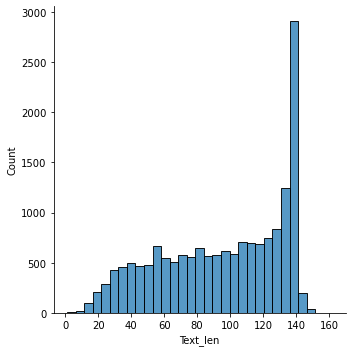

In [275]:
sns.displot(df['Text_len'])

### very few twits are of more length

In [355]:
df[df['Text_len'] >= 140]

Text  oh_label  Text_len
0      @halalflaws @biebervalue @greenlinerzjm I read...       0.0       140
1      @ShreyaBafna3 Now you idiots claim that people...       0.0       140
5      RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...       0.0       140
10     @dllvllHllvllb @hyperion5182 @PolitiBunny @The...       0.0       140
16     RT @nathanrodger: If Kat &amp; Andre were drow...       0.0       148
...                                                  ...       ...       ...
16828  RT @Janx53: @Firyayek Good vid! "When we advan...       0.0       140
16837  RT @pperrin: Oh... so Rotherham was Tony Blair...       0.0       140
16841  yeah so annoying how they're doing their jobs ...       1.0       140
16843  @jukes303 The old oil cliche again. The US pay...       0.0       140
16848  RT @colonelkickhead: Deconstructed lemon tart!...       0.0       140

[2238 rows x 3 columns]

## Plot distribution fo different sentiment

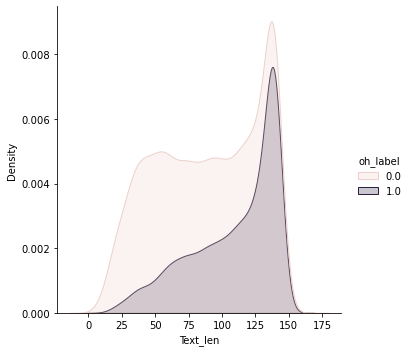

In [277]:
sns.displot(data=df,x='Text_len',hue='oh_label',kind='kde',fill=True)

## Data Cleaning

In [21]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [356]:
df['Cleaned_text'] = df['Text']

In [357]:
df.isna().sum()

Text            1
oh_label        3
Text_len        0
Cleaned_text    1
dtype: int64

In [358]:
df.dropna(inplace=True)

## Spell check 

In [238]:
# # def spell_correct(text):
# #     sample = text
# #     sample = TextBlob(sample)
# #     return sample.correct()
# df['Cleaned_text'] = df['Cleaned_text'].apply(lambda x: str(TextBlob(x).correct()))
# df

In [553]:
only_english = set(nltk.corpus.words.words())
def clean_text(text):
    
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('[%s]' % re.escape(string.punctuation), '', sample) #punctuations
    sample = re.sub('\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = re.sub('\w*\d', '', sample) #digits with trailing or preceeding text
    
    
    sample = ' '.join([w for w in nltk.wordpunct_tokenize(sample) if w.lower() in only_english or not w.isalpha()]) #doesn't remove indian languages
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = sample.strip()
    sample = " ".join([x.strip() for x in sample.split()])
    
    return sample

In [360]:
df['Cleaned_text'] = df['Cleaned_text'].apply(lambda x: clean_text(x))
df

Text  oh_label  Text_len  \
0      @halalflaws @biebervalue @greenlinerzjm I read...       0.0       140   
1      @ShreyaBafna3 Now you idiots claim that people...       0.0       140   
2      RT @Mooseoftorment Call me sexist, but when I ...       1.0        91   
3      @g0ssipsquirrelx Wrong, ISIS follows the examp...       1.0        83   
4                                 #mkr No No No No No No       0.0        22   
...                                                  ...       ...       ...   
16846  Feeling so sorry for the girls, they should be...       0.0        95   
16847  #MKR 'pretty good dishes we're happy with' - O...       0.0        85   
16848  RT @colonelkickhead: Deconstructed lemon tart!...       0.0       140   
16849  @versacezaynx @nyazpolitics @greenlinerzjm You...       0.0        82   
16850  And before you protest that you're *not* mad, ...       0.0       134   

                                            Cleaned_text  
0      i read them in change in meaning the history o...  
1      now you claim that people who tried to stop hi...  
2      call me but when i go to an auto place id rath...  
3                   wrong the example of and the exactly  
4                                      no no no no no no  
...                                                  ...  
16846  feeling so sorry for the they should be safe a...  
16847  pretty good were happy with well never eating ...  
16848  lemon we please go just one season of without ...  
16849              you are too stupid to talk to blocked  
16850  and before you protest that not mad theres not...  

[16848 rows x 4 columns]

In [317]:
def display(text):
    print(text)

In [243]:
df['Cleaned_text'].apply(lambda x: display(x))

i read them in change in meaning the history of slavery
now you claim that people who tried to stop him from becoming a terrorist made him a terrorist brain dead
call me but when i go to an auto place id rather talk to a guy
wrong the example of and the exactly
preacher who and tortured his five daughter to death is after
not but most are bad
going to make some any but i
how dare you have is a fantastic way to dehumanize someone
theres something wrong when a girl street striker
not on the and i dont run blocking manually for now
a good is good despite his bad religion not because of it
i help everyone that not here to pass judgment on anyone that comes looking for help
yeah its about human life idiot something a genocidal wouldnt understand
eventually most of them were like wait harper harper and i still dont know how to adjust to this
the delusion factory is running full speed and the are
if kat were in a river you only had the chance to save one of them what type of sandwich would yo

still at the stage where given up on finding a good task list that with my so i use a
oh how strange glorious leader of a campaign that is supposedly not about harassment is harassment
oh if only colin washed his hair
really it out this year
court armed wing as terrorist organization
so the general leading the assault on in is from the action not my of valiant leadership
it read to me like you like him he yr book
strategic or talentless hack you be the judge
and here comes the kitchen crew
was king he could do what he none of your garbage any bearing on being a
they are trying to replace with a gal on the dollar bill not but spend all our money anyway
do you even plate
oh i didnt know you were coming to from via
when you have that many you know precisely what
the idea that the us is trying to provoke russia in light of invasion of and e is absurd
i thought we were through the instant restaurant please not another
ready to run was on and i
id score just to kick crazy out
and calling it 

kat you snake even if you win and open your own restaurant going to go
believe that the existence of a rape culture is solely down to the
i think that your are telling you stuff to jack up moral and they will try something but it will fail see
just kat and it was the best thing viva la
kat and got through on strategy and not score how embarrassing you should be ashamed or the biggest loser
and are going down to sudden death town
twitter is that what i keep the wrong button
cant lie this was generally clever funny and relatable without it with girlishness
why do continually cook they have never done or use they have never used
another job rejection
kat and dont deserve to stay in the competition its about good cooking not strategic voting
kat you are the biggest mole i hope you choke
call me but the sound of female hockey screeching at the ice from is causing me pain id rather hear
again again u want us to go this again give us a break stop treating the golden goose like
for the who is 

someone else which people are actively searching her name which is still creepy
we want to stay in this competition because we havent finished telling everyone how pretty we are
pete would love it
what are you stupid there is nothing that to the inhumanity and barbarity of
no more so than the who consider their birthright to be global domination
after that knockout round this is how many are left on my kitchen
are looking delicious
thats why there are many p matching or is
just discovered what when jeans are too big while wearing over a swim whelp time to make a belt
was a murderer wasnt was a rapist wasnt
not but i dont think are funny
never stopped its war on never stopped its war on humanity
which is fine i guess but she went out of her way to talk to interesting no
the were really thinking ahead when they sent to all those religious
if i was looking for id point out a white dude in a position of power accused a minority of bullying him p
dump the guy bring back
basically the are a 

when are the food trucks make a comeback
been told pretty good at drumming up suspense
we wish it were only a few
me too oddly not a bit
not but something aint right when calling a football game
not ignore the she received as well
the fact that you dont think this tripe is is the part
and is a total fruit cake kat is so delusional that a better grip on reality
insane to allies and then wonder why you have so few thats why radical feminism al
it was the best of times it was the worst of times but she had amazing i say
trying so hard to be charming i have nothing to add
lots of willing to give u that punch missing colin
thats just a one
ago my ass that was the beginning and it never stopped it is an ingrained part of
when a girl more buff than me
courtesy of our friend the of the board
exactly how is any male supposed to protect himself against the scenario u
since both the and your prophet and you are talking like a hypocrite
thats not what i with dumb but yeah i see what u mean the fac

is a fork that is mostly funded by the organization that marketing its a on top of
think we can all agree kat and will not get choice
look dude i want to be nice to you but off you got by a bot leave me alone
ranch dressing on pizza no pineapple was bad enough from these
and yet you felt the need to tweet this drivel
all that collusion in the community sure is hard to keep track of
how unfortunate theyre
multiple this is all a lot of effort though most just pick a new target
nice interface much than the setup that
your logic is dont touch that pile of trash because theres another pile under it
kat the only in history to give a and all for strategy you dont deserve to be in the competition
how is this a thing
lemon tart
so hilarious u write ur own material a lot of call me but those are and their dont matter
ben open to meeting good like but can i say nicely all a lemming
i actually got an answer from a feminist today a remarkably stupid one but an answer nonetheless
no in want to creat

this is basically going to be like but for p
now go back and see where the rank
what the hell were you thinking with your name
people say write what you know sometimes i think people should know more at
call me but if you need a specific training segment for coaching it the purpose of equality across
not to mention these same on have super inflated considering they didnt cook that well and arent very nice
at this rate maybe theyll all be rocking up to my house soon a meal surprise round
na na na na na na na na na na na na na na na na not but female are all
my face every time i hear or see it dont get stuck
unfortunately russia is a source of terror all those in e are not there for humanitarian reason
they made in the past i hope learned but the way they the situation been outstanding
sorry wat
i would have to do a search so forget that one for now
charity auction p
he got one serve not two had to defend the also
go the fake tan on one of the way too powdery
this is the joke
hey thought

0        None
1        None
2        None
3        None
5        None
         ... 
16846    None
16847    None
16848    None
16849    None
16850    None
Name: Cleaned_text, Length: 16078, dtype: object

In [361]:
only_english = set(nltk.corpus.words.words())
def remove_otherlanguage(text):
    sample = text
    sample = ' '.join([w for w in nltk.wordpunct_tokenize(sample) if w.lower() in only_english or not w.isalpha()]) #doesn't remove indian languages
    return sample

In [362]:
df['Cleaned_text'] = df['Cleaned_text'].apply(lambda x: remove_otherlanguage(x))

In [363]:
df

Text  oh_label  Text_len  \
0      @halalflaws @biebervalue @greenlinerzjm I read...       0.0       140   
1      @ShreyaBafna3 Now you idiots claim that people...       0.0       140   
2      RT @Mooseoftorment Call me sexist, but when I ...       1.0        91   
3      @g0ssipsquirrelx Wrong, ISIS follows the examp...       1.0        83   
4                                 #mkr No No No No No No       0.0        22   
...                                                  ...       ...       ...   
16846  Feeling so sorry for the girls, they should be...       0.0        95   
16847  #MKR 'pretty good dishes we're happy with' - O...       0.0        85   
16848  RT @colonelkickhead: Deconstructed lemon tart!...       0.0       140   
16849  @versacezaynx @nyazpolitics @greenlinerzjm You...       0.0        82   
16850  And before you protest that you're *not* mad, ...       0.0       134   

                                            Cleaned_text  
0      i read them in change in meaning the history o...  
1      now you claim that people who tried to stop hi...  
2      call me but when i go to an auto place id rath...  
3                   wrong the example of and the exactly  
4                                      no no no no no no  
...                                                  ...  
16846  feeling so sorry for the they should be safe a...  
16847  pretty good were happy with well never eating ...  
16848  lemon we please go just one season of without ...  
16849              you are too stupid to talk to blocked  
16850  and before you protest that not mad theres not...  

[16848 rows x 4 columns]

In [247]:
df['Cleaned_text'].apply(lambda x: display(x))

i read them in change in meaning the history of slavery
now you claim that people who tried to stop him from becoming a terrorist made him a terrorist brain dead
call me but when i go to an auto place id rather talk to a guy
wrong the example of and the exactly
preacher who and tortured his five daughter to death is after
not but most are bad
going to make some any but i
how dare you have is a fantastic way to dehumanize someone
theres something wrong when a girl street striker
not on the and i dont run blocking manually for now
a good is good despite his bad religion not because of it
i help everyone that not here to pass judgment on anyone that comes looking for help
yeah its about human life idiot something a genocidal wouldnt understand
eventually most of them were like wait harper harper and i still dont know how to adjust to this
the delusion factory is running full speed and the are
if kat were in a river you only had the chance to save one of them what type of sandwich would yo

camper whats bubble squeak its like leftover roast you need to work on your pitch
maple bacon how can you go wrong
i am offended by the grammar
will the dev that never forgotten to put in sleep or increment or wrote a poorly designed loop please stand up
order all to vacate their bases and move all from coalition after k
dont think that it wont go dont put on a cape unless you plan on being a hero its not a photo its a job
oh gosh no the problem is that been traveling and forgot to do my garrison stuff
yeah i something that mounted directly to my desk i get and move furniture sometimes
painting as inhuman is exactly what the does to
kim un
used to be
maybe you should teach that respect to like these
i think and tony might be in trouble if they scrape through be because they are than the
even if kat gave them the they they still would be there and the still gone home
i cant stand kat
based on based on kat it out
kat is fair hypocrite
because that like torture to me how can you defend it

and annoy me
absolutely still cracking up that the one time i wear a superhero cape on i run into someone that i know
well they there dessert
ash and camilla looking great at the today port
hooked up to all brains while driving
is for what doing i want something more
i am seriously considering not watching just because i have to see face god i want to slap it with a spatula
every guy that the only thing that will make a woman happy is making any man a sandwich
hope they get booted next round
alima have you how in the slave market
they are a laugh arent they
sometimes my such stupid that i have to remind myself that i her from knowing about much of the horrible stuff
but for someone who on their twitter account you are being rather you not
dont do i the bot
become a v showdown who can talk more talk
its like reading easy to spend too much time reading garbage instead of doing cool
video of execution was broadcast on big and you can hear yelling
therefore resulting in the fact that every

in the wake of the it me off to hear the to lessen role
not sure was sent
with the knowledge that your are reading and their hearts ring out in concert and support even if quietly
yeah let the have it and hope they come for us last
thats actually so kat and suck hair they should of gone they cant cook they are
alima the were won because gave his of what they stole
back then men were in charge and were to them today are just as equal and even better not sex
i it too funny i saw this one today
laughing kat and laugh at and not doing well and then they completely fail
this is a museum piece sir
calm your hair
state men in after their fail to wear new
one more propaganda troll blocked
hell yeah awesome post on
as of tonight i am officially finished with this show seen plenty of before but this is ridiculous m
i love it when these compromise their because the channel script tell them to no credibility
thats old school i didnt even think of that
main road junction is under control of we keep

your joke is like misogynist magnetic poetry thrown haphazardly onto a
i know you cant leave country without male permission
and if someone to leave then him an apostate and that he be
should never participate in no shave you should only have hair on your head
white house to call while on state t
i know what a straw man is what is the straw man here
kat and much
driverless that would be an improvement for some of the on the road
the confidence was way too much
the fat south are feeling hopeful
about to meet this puppy shepherd mix a bit bigger than i well see
not a fan of chicken liver entree
no i block quickly from my the go to my phone but always willing to unblock
theres a police boat over there this is a crime against cooking i fully approve now of colin being a jud
where is the location of
there is nothing incorrect about the generalization look at minority in
i dont even know what that is or where its from was that supposed to be funny it wasnt
big deal the spell checker its own 

kat and the competition only a short time showing yourself as to all of is going to last a lot longer
are so trained to see as quiet that when we engage with substance its seen as sudden aggression
yes amnesty will put us over the edge fiscally and crime and death will skyrocket
this could be close
i spy my with little eye two missing
i have no idea is going on or why i am in this tweet
its actually two separate real insane
the question is if are being targeted not if that are getting some damage
like cracker patriarch is at it again
to all you people saying dragging on theres an after these instant its only more
i the end of to watch what
the old school is not just old school
not sure how much more of this crap i can endure
if you tell me to get one of those weird hexa i will never talk to you again
funny as a in an elevator they have this lemon tart worse than did
yep except the study author it does not prove bias
i think i just got turned off lemon
exactly is really not theirs to re

learn how to tell other they should study something other than
listening to on satellite radio and sorry but these are awful not but the woman ann
theres also that made about a fever which turned into a heart attack in later of the story
my they argue to deny men choice they literally argue abortion is not a reproductive right
then shut down any imam and mosque that is the home mosque for anyone joining terror
she will often not know it should be opt in not opt out so that he must be told or else they will hide it
at if you need my pager address for urgent i can give that to you
i love how auto everything like this even when you say theyre
face at the table on hearing strategic scoring delusion
kind of want to jump through my and punch kat in the face hope other vote strategically for her now bitch
face palm face palm the model show is i watch for the cooking
cant sleep and came across this
nothing like a little colin to cheer up this night after a day
happy birthday
even if i didnt li

0        None
1        None
2        None
3        None
5        None
         ... 
16846    None
16847    None
16848    None
16849    None
16850    None
Name: Cleaned_text, Length: 16078, dtype: object

## remove stop words

In [364]:
stops = set(stopwords.words('english'))
def remove_stop_words(text, cores = 2):
    
    sample = text
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)
    
    return sample

In [365]:
df['Cleaned_text'] = df['Cleaned_text'].apply(lambda x :remove_stop_words(x))
df

Text  oh_label  Text_len  \
0      @halalflaws @biebervalue @greenlinerzjm I read...       0.0       140   
1      @ShreyaBafna3 Now you idiots claim that people...       0.0       140   
2      RT @Mooseoftorment Call me sexist, but when I ...       1.0        91   
3      @g0ssipsquirrelx Wrong, ISIS follows the examp...       1.0        83   
4                                 #mkr No No No No No No       0.0        22   
...                                                  ...       ...       ...   
16846  Feeling so sorry for the girls, they should be...       0.0        95   
16847  #MKR 'pretty good dishes we're happy with' - O...       0.0        85   
16848  RT @colonelkickhead: Deconstructed lemon tart!...       0.0       140   
16849  @versacezaynx @nyazpolitics @greenlinerzjm You...       0.0        82   
16850  And before you protest that you're *not* mad, ...       0.0       134   

                                            Cleaned_text  
0                    read change meaning history slavery  
1      claim people tried stop becoming terrorist mad...  
2                  call go auto place id rather talk guy  
3                                  wrong example exactly  
4                                                         
...                                                  ...  
16846                  feeling sorry safe kat going home  
16847          pretty good happy well never eating place  
16848  lemon please go one season without someone cal...  
16849                                stupid talk blocked  
16850       protest mad theres much reason youd feminism  

[16848 rows x 4 columns]

In [250]:
df['Cleaned_text'].values

array(['read change meaning history slavery',
       'claim people tried stop becoming terrorist made terrorist brain dead',
       'call go auto place id rather talk guy', ...,
       'lemon please go one season without someone calling something',
       'stupid talk blocked',
       'protest mad theres much reason youd feminism'], dtype=object)

In [366]:
df.isnull().sum()

Text            0
oh_label        0
Text_len        0
Cleaned_text    0
dtype: int64

## we hve some rows removed while removing stop words

In [367]:
df[df['Cleaned_text'] == ""]

Text  oh_label  Text_len  \
4                                 #mkr No No No No No No       0.0        22   
72            Cc @SwiftOnSecurity http://t.co/RK2U5igiwU       0.0        42   
88                                 @mistertodd yessssss.       0.0        21   
108       @harmlesstree2 Here2.  https://t.co/xWJzpSodGj       0.0        46   
124    @OdiniaInvictus @SirajZarook @BilalIGhumman @I...       0.0       137   
...                                                  ...       ...       ...   
16771            @ROJNAME_english http://t.co/Ej5MsCentH       0.0        39   
16794  @dankmtl @AAlwuhaib1977 @PeaceNotHate_ No assh...       1.0       126   
16809                     Portland IKEA: now with birds!       0.0        30   
16813                   @randi_ebooks @desertfox899 what       0.0        32   
16831            Tarts for tarts ;) #mkr #mykitchenrules       1.0        39   

      Cleaned_text  
4                   
72                  
88                  
108                 
124                 
...            ...  
16771               
16794               
16809               
16813               
16831               

[770 rows x 4 columns]

In [253]:
## replace empty rows with np.nan and drop those rows

In [368]:
df['Cleaned_text'].replace('', np.nan, inplace=True)
df.dropna(subset=['Cleaned_text'], inplace=True)
df.reset_index(inplace=True)

In [369]:
df

index                                               Text  oh_label  \
0          0  @halalflaws @biebervalue @greenlinerzjm I read...       0.0   
1          1  @ShreyaBafna3 Now you idiots claim that people...       0.0   
2          2  RT @Mooseoftorment Call me sexist, but when I ...       1.0   
3          3  @g0ssipsquirrelx Wrong, ISIS follows the examp...       1.0   
4          5  RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...       0.0   
...      ...                                                ...       ...   
16073  16846  Feeling so sorry for the girls, they should be...       0.0   
16074  16847  #MKR 'pretty good dishes we're happy with' - O...       0.0   
16075  16848  RT @colonelkickhead: Deconstructed lemon tart!...       0.0   
16076  16849  @versacezaynx @nyazpolitics @greenlinerzjm You...       0.0   
16077  16850  And before you protest that you're *not* mad, ...       0.0   

       Text_len                                       Cleaned_text  
0           140                read change meaning history slavery  
1           140  claim people tried stop becoming terrorist mad...  
2            91              call go auto place id rather talk guy  
3            83                              wrong example exactly  
4           140              preacher tortured five daughter death  
...         ...                                                ...  
16073        95                  feeling sorry safe kat going home  
16074        85          pretty good happy well never eating place  
16075       140  lemon please go one season without someone cal...  
16076        82                                stupid talk blocked  
16077       134       protest mad theres much reason youd feminism  

[16078 rows x 5 columns]

In [256]:
df['Cleaned_text'].apply(lambda x: display(x))

read change meaning history slavery
claim people tried stop becoming terrorist made terrorist brain dead
call go auto place id rather talk guy
wrong example exactly
preacher tortured five daughter death
bad
going make
dare fantastic way dehumanize someone
theres something wrong girl street striker
dont run blocking manually
good good despite bad religion
help everyone pass judgment anyone comes looking help
yeah human life idiot something genocidal wouldnt understand
eventually like wait harper harper still dont know adjust
delusion factory running full speed
kat river chance save one type sandwich would
literally site today
juxtaposition
woo cant wait see
tend document hair color later pic old
according holly shore sassy halfway slut classy
vomit
looking forward ash camilla butting drama great
food poisoning
brain dead repeat said million times
think two facing sudden death
time channel reconsider association dangerous man
male time collect trash
dont believe certain
sell get men
sure

want hear collusion
base army army one got close
complain quality historical context
physically n
gosh many surprise show need
surely dont anything masthead posting get damn person
men sold slavery love
get stuck head kat
u write come sign must tall ride emotional
like telling unlearn hatred
kat carol
p
experience similar key dont know twitter client additional
actually cant believe make pay food show
fear
catwalk place one foot front
explain
kat proof majority must wa one truly awful human bad though
god cant use opener joke know know blonde
news full white people dont understand killing demand see manager
raping world got size first
different racist equal nope salon
today one used word describe football defeat one step forward two back
new ghost woman cast wont
usually optimistic people ability change enough background story reliable
walter would love variety
coming hypocrite religion declared war humanity population
toss
hope pay
want destroy scum like excuse
oh
last night
ill take 

lack two replace one man
far many left show ago
disappointing made
bye bye ego might go notch
literally told dude could keep sponsorship money rather make effort include say aga
horse accepted multiple say must
double
friend zone please cut thanks management
massive forehead stays damn
love power brick hub big
saw phone didnt see salvation army
stopped would peace
random bombardment chemical chemical blown
often pay like problem charging
could hold still catch every night
either ignorant religion liar tell
love baking banana
thank random person said
two kelly group
part show awkward
bring back interesting thank god
start needs shut tech already
moment busy trying track conspiracy
amazing would never relive
oh kat never mind
really bad
obviously big boss fake ever seen woman little luggage
yet hear one good woman play play announcer
near danger meet
fight war earnest never know us
yet talk
tired strength defined solely upper body muscular strength inferior weak
dealing dont threaten app

ruby p doesnt good module streaming forced get better ruby good stuff
ill make simple
kat still wasnt biggest fan much kat
sure stream ill least vine making announcement ill
contact today find better
happiest ever
mad props well done
forgot annoying
early morning baking baked raspberry ripple cheesecake kitchen official site
female choose work
happy life cant tequila
today still peace
day day catch later hit medium emergency
thought would fairly easy implement get received blocked
list
sigh many people bad understanding dos
militia nearly inhuman
doesnt matter support since separation church state
old hat cleaning car job cutting grass job dish
dessert making lemon tart know
problem repress contradiction
many research exhaustive list
hate religion based hatred jihad
people assume saw blocked nope blocked knew use block list
test
domestic violence data lying
damn kat hope karma comes around arse
target demographic apparently fun fact draper tea
men use word ladies ladies pretty bad driv

bunch clip hair longer hair decided let use
block bot tool share block particular one via
theyll go away cuckoo
reverse doesnt exist murderous
meanwhile week one married bought sold
dog woke crying past cannot butt
bitch whore slut sick change speech change mind
yes try fool people believing lie religion peace
apparently
later
hey found oh whatever damsel distress oh gosh stop hapless victim
say
actually nothing think answer question
past allegedly even case gang f
cool story believe male female extent
receive code number must use title
minority next door murdering
would give ten push kat
break
strategic unfair voting dont like either team least werent like kat disappointed
yeah men beat point
know editor
love colin
terrorism formula ruin attempt get drive
rust course greedy private like north
yeah anti excuse anti
got get sheep feminist
must admit belong kitchen worth chuckle
love idiot national claim terrorism nothing one read
thats get family member random rage
whereas prostitution 

intent linking stated backing attempt save face apology
prophet rape like yes prophet tell cover stay home like yes
russia pess freedom
lunch prob busy p might able breakfast
proof liar propagandist
individual listing block list worn pride
love put kat place cook good food get good score
isolation
get page
wait
n best
many sound amazing wouldnt able make mind bacon
exactly
prophet used attack murdering crying
nothing religion
bring barely remember second group let alone first
race poop brains
guy harper met
breaking ambush near village
surely
cant wait see finally
could reformed
show end theyll spring another surprise round great great great g
nope democracy man vote sword two cannot coexist
want panel tech tearing
ghazi fire mob led
got one cheap way much fun
tough talk behind
never one perfect person someone massive
feather museum
kat get stay seriously unfair strategic scoring karma
upset arent getting free next three
ugh cant nothing quite degrading man feather duster
hope forget r

took male would
point live different
nervous kat tear new stays show
different impact depending power hard concept clarify
seen crap example never million
never thought id feel bad episode got right like punching
less bad genuinely equal equality la young
saw verbatim men selfish jerk think child
people right free speech would free speech
anyone video
tweet may actionable
always looking forward see rob outfit day
level transference tone deafness one amazing
claim dont need fought kind sick inhuman disgusting animal
sense also horrible block become muscle memory p
god series going end
thanks
sick word sassy
chapter history
sudden death kat funny would
feeling whole lot pain em
propaganda
world care declared war humanity ago
agree
hold phone kat cook crap think amazing
feeling quite sorry
hot pot especially drunk unconscious
wasnt aware man spoke miss memo
wasnt paying attention
surprise one dinner breakfast
dont support kind compare
time
honestly want meet guerrilla holding create token

0        None
1        None
2        None
3        None
5        None
         ... 
16846    None
16847    None
16848    None
16849    None
16850    None
Name: Cleaned_text, Length: 16078, dtype: object

In [370]:
only_english = set(nltk.corpus.words.words())

In [297]:
len(only_english)

235892

In [371]:
only_english = set(nltk.corpus.words.words())
def remove_non_eng_words(text):
    
    sample = text
    sample = [word for word in sample.split() if word in only_english]
    sample = ' '.join(sample)
    
    return sample

In [372]:
df['Cleaned_text'] = df['Cleaned_text'].apply(lambda x :remove_non_eng_words(x))
df

index                                               Text  oh_label  \
0          0  @halalflaws @biebervalue @greenlinerzjm I read...       0.0   
1          1  @ShreyaBafna3 Now you idiots claim that people...       0.0   
2          2  RT @Mooseoftorment Call me sexist, but when I ...       1.0   
3          3  @g0ssipsquirrelx Wrong, ISIS follows the examp...       1.0   
4          5  RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...       0.0   
...      ...                                                ...       ...   
16073  16846  Feeling so sorry for the girls, they should be...       0.0   
16074  16847  #MKR 'pretty good dishes we're happy with' - O...       0.0   
16075  16848  RT @colonelkickhead: Deconstructed lemon tart!...       0.0   
16076  16849  @versacezaynx @nyazpolitics @greenlinerzjm You...       0.0   
16077  16850  And before you protest that you're *not* mad, ...       0.0   

       Text_len                                       Cleaned_text  
0           140                read change meaning history slavery  
1           140  claim people tried stop becoming terrorist mad...  
2            91              call go auto place id rather talk guy  
3            83                              wrong example exactly  
4           140              preacher tortured five daughter death  
...         ...                                                ...  
16073        95                  feeling sorry safe kat going home  
16074        85          pretty good happy well never eating place  
16075       140  lemon please go one season without someone cal...  
16076        82                                stupid talk blocked  
16077       134       protest mad theres much reason youd feminism  

[16078 rows x 5 columns]

In [373]:
df["Cleaned_text"] = df["Cleaned_text"].apply(lambda x: re.sub(' +', ' ', x))

In [374]:
df.head(10)

index                                               Text  oh_label  \
0      0  @halalflaws @biebervalue @greenlinerzjm I read...       0.0   
1      1  @ShreyaBafna3 Now you idiots claim that people...       0.0   
2      2  RT @Mooseoftorment Call me sexist, but when I ...       1.0   
3      3  @g0ssipsquirrelx Wrong, ISIS follows the examp...       1.0   
4      5  RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...       0.0   
5      6  RT @Millhouse66 @Maureen_JS nooo not sexist bu...       1.0   
6      7  Going to make some pancakes.....Don't hve any ...       0.0   
7      8  RT @ahtweet: @freebsdgirl How dare you have fe...       0.0   
8      9  RT @Newmanzaa: There's something wrong when a ...       1.0   
9     10  @dllvllHllvllb @hyperion5182 @PolitiBunny @The...       0.0   

   Text_len                                       Cleaned_text  
0       140                read change meaning history slavery  
1       140  claim people tried stop becoming terrorist mad...  
2        91              call go auto place id rather talk guy  
3        83                              wrong example exactly  
4       140              preacher tortured five daughter death  
5        74                                                bad  
6       105                                         going make  
7        94              dare fantastic way dehumanize someone  
8        94         theres something wrong girl street striker  
9       140                         dont run blocking manually

## Lemmetaization

In [375]:
def get_wordnet_pos(word):
    
    treebank_tag = nltk.pos_tag([word])[0][1]
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    elif treebank_tag.startswith('C'):
        return wordnet.NOUN
    else:
        return ''

# Lemmatizing the data
# Steps to convert : Document -> Sentences -> Tokens -> POS -> Lemmas
lemmatizer = WordNetLemmatizer()
def lemma_clean_text(text):
    sample = text
    sample = sample.split()
    sample = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in sample]
    sample = ' '.join(sample)
    
    return sample

In [336]:
df['Cleaned_text'] = df['Cleaned_text'].apply(lambda x :lemma_clean_text(x))
df

read change meaning history slavery
read NN
change NN
meaning NN
history NN
slavery NN
claim people tried stop becoming terrorist made terrorist brain dead
claim NN
people NNS
tried VBN
stop NN
becoming VBG
terrorist NN
made VBN
terrorist NN
brain NN
dead JJ
call go auto place id rather talk guy
call NN
go VB
auto NN
place NN
id NN
rather RB
talk NN
guy NN
wrong example exactly
wrong JJ
example NN
exactly RB
preacher tortured five daughter death
preacher NN
tortured VBN
five CD
daughter NN
death NN
bad
bad JJ
going make
going VBG
make VB
dare fantastic way dehumanize someone
dare NN
fantastic JJ
way NN
dehumanize VB
someone NN
theres something wrong girl street striker
theres NNS
something NN
wrong JJ
girl NN
street NN
striker NN
dont run blocking manually
dont NN
run VB
blocking VBG
manually RB
good good despite bad religion
good JJ
good JJ
despite IN


KeyError: ''

In [337]:
df['Cleaned_text'].apply(lambda x: display(x))

read change meaning history slavery
claim people tried stop becoming terrorist made terrorist brain dead
call go auto place id rather talk guy
wrong example exactly
preacher tortured five daughter death
bad
going make
dare fantastic way dehumanize someone
theres something wrong girl street striker
dont run blocking manually
good good despite bad religion
help everyone pass judgment anyone comes looking help
yeah human life idiot something genocidal wouldnt understand
eventually like wait harper harper still dont know adjust
delusion factory running full speed
kat river chance save one type sandwich would
literally site today
juxtaposition
woo cant wait see
tend document hair color later pic old
according holly shore sassy halfway slut classy
vomit
looking forward ash camilla butting drama great
food poisoning
brain dead repeat said million times
think two facing sudden death
time channel reconsider association dangerous man
male time collect trash
dont believe certain
sell get men
sure

wealthy
casting people trawl dark seriously delusional supremely misguided plain rotten
kat needs hat see go
apparently fascist run
twitter raping yesterday also saying get little bes
kat
cleric sun around earth understand skill jihad science
else looking forward kat pending elimination
star declared bankruptcy money ie multimillionaire sons guilty
monster
kat
squad retook south last night
whatever man woman never let go
honestly forgot name p doesnt really matter working real data
sorry call cannot respect opinion entertain sports even
hate big smug face constant split fringe much kat
incidentally know editor woman tech factual
could get hurt someone could come hell people shown office
someone valid emotional
similar talk ill writing regardless anyone west coast venue happy talk
cant stand female play play football every time hear holly game ca
already know reach doesnt really extend beyond follower count matter
military shipped
dont like wishing bad luck gosh really dislike kat much 

base army army one got close
complain quality historical context
physically n
gosh many surprise show need
surely dont anything masthead posting get damn person
men sold slavery love
get stuck head kat
u write come sign must tall ride emotional
like telling unlearn hatred
kat carol
p
experience similar key dont know twitter client additional
actually cant believe make pay food show
fear
catwalk place one foot front
explain
kat proof majority must wa one truly awful human bad though
god cant use opener joke know know blonde
news full white people dont understand killing demand see manager
raping world got size first
different racist equal nope salon
today one used word describe football defeat one step forward two back
new ghost woman cast wont
usually optimistic people ability change enough background story reliable
walter would love variety
coming hypocrite religion declared war humanity population
toss
hope pay
want destroy scum like excuse
oh
last night
ill take saying yes hit way
t

said yummy yummy yummy get
hey dad
wish bell would ring would rain every time said joke bingo card anticlimactic
men dont think ever envious men find feminine trait lots
pile manure human freedom human life human expression endless divisiveness
god truly projection
kat absolutely disgusting human
ill help dough coming
thats full never done days work
cannot stand feminist
tweet taken way pretty sure definition cant drunk
cant take action offering advice assistance person targeted report police
kat actually daughter found another use
thats definition call feel men appropriate life
name prominent please
yes
us keynote got show harassment happening live us harassment
graduated dos school flying colors
took village north tal afar
someone going home obviously cannot cook
reconstructed
every dev
algebra came
everybody passion million good
nothing gender like remake perfectly good film
nope eight little vermin al air base quickly
also angry worse death getting used
theres nothing female sports

kat loving negative
lone nut
us kill worthless without loosing man
number actually getting ridiculous stop show way much
walking wrong whole life
actually u need help call actually nancy warren
half dozen clearly document criminality good night
want toast
jelly much kat catch
turned tele spindle
hear hot pretty sassy like us one time
stop smiling kat
unfortunate id like leave twitter avenue available targeted
hit way wearing would
collective across country kat wont last
ever seen female even like behind wheel car
real attack al would yield killing ground lots open space hide behind
getting ready kill stuff
dont laugh kat
aw thanks p
notice didnt see kat cut
turkey going another secularism
blonde chick wearing hot pink dress
positive negative nancy thats corny
ease one scary least think acting rather th
always expect read
could stop watching crap like
refined pretty like something blind kindergarten student plate
read land oh salty small fish five new cook book cooking ahead
thanks thin

go vile inhuman religion
name many since twitter
utterly way kat better
question media see mention clem open bigotry nope narrative
head wiggle quagmire
need stay
glad hear peter respect assessment
kat awful wrong two
oh instant
reaction kat didnt get
interested childish
keep talking hot hot
trying decide time contact police call never thought id say unless involved
arent withdrawing silence talking abuse get end
cant believe page attack dont
need
anonymous
democracy bow turkey h
famous radical may next prime
oh look new idea synergistic cross promotional marketing paradigm thingy range
kat reckon may whole viewer population
mob violence
fair none anything even free speech matter p
husband pregnant wife sexual abuse
whatever country one group another
stop saying
alima nonsense like cult follower
dessert going
getting period thought dying
point pete appeal public
ever get dealing walking remember dont like
even going lie giggle little bit inside
corruption
hope try take wrestling respon

pocky
doesnt liberate anything dont want rest
going secular disgusting ever
monk touch karma someone else keep dont get killing blow credit teammate
real expansion already local loyalty worst worst
short hilarious fail ever seen
never used ice cream maker
hope dont go sudden elimination please
never thought id say hope butcher make tonight kat
didnt even say let alone undermine authority assume much step f
needs propaganda war publish
maybe learn lie
near
song ranked record received
equally
even cracked better
obviously student fed suck
could mayor heartbeat could murder blasphemy
al man savage way didnt rip
nobody dry sausage
false rape accusation might work
oh put bloody kat still
rest world every whim go enjoy shoot huge first foremost
russia sent arms port w air
hey everybody another funny thing
saw days ago brilliant need fifty like
realize powerful feminism really
dont care none business religion someone
oh south werent happy theyll gone soon
shut
ugh year
call whatever men shoul

kat class bad bra
view
pork like pork
bill warner versus
would rather involved debate
installer still install ask ugh oracle even go
theres still need island
view
gross
good time confront cult hatred murder
hope round cant cook
doubt especially respect men ever
thick juicy pork poor
kat make theyre seriously awful
lip freak
anyone else kat recently psych ward
last least bus talking ran friend
alima hello look research
best thing
think know way around well around
really enjoying one product stick gum also theres cupcake flavored please let cupcake pic
hear north glad made snow
doubt less true
thought female ghost could think
largely tempered former tax bracket although like idea flat tax doesnt work well
oh kat something new every night make look even like hateful twat
gay
used talk everything weird much attention
come joke men way round
actually even dictionary definition feminism unequal dont see telling
dont dare call dollar every time woman say men th
seven different married directl

0        None
1        None
2        None
3        None
5        None
         ... 
16846    None
16847    None
16848    None
16849    None
16850    None
Name: Cleaned_text, Length: 16078, dtype: object

In [332]:
nltk.pos_tag(['five'])[0][1]

'CD'

In [338]:
## Rmoving all single letters in the sentence

In [ ]:
' '.join( [w for w in input.split() if len(w)>1] )

In [376]:
def remove_single_char(text):
    
    sample = text.split()
    sample = [w for w in sample if len(w)>1]
    sample = ' '.join(sample)
    
    return sample

In [377]:
df['Cleaned_text'] = df['Cleaned_text'].apply(lambda x :remove_single_char(x))
df

index                                               Text  oh_label  \
0          0  @halalflaws @biebervalue @greenlinerzjm I read...       0.0   
1          1  @ShreyaBafna3 Now you idiots claim that people...       0.0   
2          2  RT @Mooseoftorment Call me sexist, but when I ...       1.0   
3          3  @g0ssipsquirrelx Wrong, ISIS follows the examp...       1.0   
4          5  RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...       0.0   
...      ...                                                ...       ...   
16073  16846  Feeling so sorry for the girls, they should be...       0.0   
16074  16847  #MKR 'pretty good dishes we're happy with' - O...       0.0   
16075  16848  RT @colonelkickhead: Deconstructed lemon tart!...       0.0   
16076  16849  @versacezaynx @nyazpolitics @greenlinerzjm You...       0.0   
16077  16850  And before you protest that you're *not* mad, ...       0.0   

       Text_len                                       Cleaned_text  
0           140                read change meaning history slavery  
1           140  claim people tried stop becoming terrorist mad...  
2            91              call go auto place id rather talk guy  
3            83                              wrong example exactly  
4           140              preacher tortured five daughter death  
...         ...                                                ...  
16073        95                  feeling sorry safe kat going home  
16074        85          pretty good happy well never eating place  
16075       140  lemon please go one season without someone cal...  
16076        82                                stupid talk blocked  
16077       134       protest mad theres much reason youd feminism  

[16078 rows x 5 columns]

In [343]:
df[df['Cleaned_text'] == ""]

Text  oh_label  Text_len  \
149                                  @JillWetzler I ❤️ u       0.0        19   
247               @Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG       0.0        38   
333          .@rosesareswift K... http://t.co/IyxiisJajP       1.0        43   
1486               @shereeny @caulkthewagon there is. :P       0.0        37   
2943                               @LewisDorigo no ms :P       0.0        21   
3718          @aussielung And FYI "Can u" is asking YOU.       0.0        42   
4028                                        @g56yu  Who?       0.0        12   
6523                           @lethalcupcake awwwww! :P       0.0        25   
7422   @harmlesstree2 The Jews were murdered for 1400...       1.0       110   
9147              @nwOryzen Borrowed from Q on Startrek.       0.0        38   
9240                                @g56yu What is that?       1.0        20   
9789                             @mikeage what isn't? ;P       0.0        23   
10700                            @DennisCEarl w not v ;)       0.0        23   
10896                       No u. http://t.co/zOr0eWahSS       0.0        28   
11351                       @oscartaracena I'm in SF. :P       0.0        28   
14615                   @Manami_Fox @eevee @femfreq no u       0.0        32   
14637                                @Veeren_Jubbal no u       0.0        19   
15017  RT @P_Filippelli: @YesYoureSexist just stating...       0.0        54   
15701                   @juliaferraioli i have those. :P       0.0        32   
16086             @Te4m_NiGhtM4Re http://t.co/CHYCjtepYf       0.0        38   
16269              .@jaasboyle K. http://t.co/0o9GQ6jFsY       1.0        37   

      Cleaned_text  
149                 
247                 
333                 
1486                
2943                
3718                
4028                
6523                
7422                
9147                
9240                
9789                
10700               
10896               
11351               
14615               
14637               
15017               
15701               
16086               
16269

In [378]:
df['Cleaned_text'].replace('', np.nan, inplace=True)
df.dropna(subset=['Cleaned_text'], inplace=True)
df.reset_index(drop=True,inplace=True)

In [379]:
df

index                                               Text  oh_label  \
0          0  @halalflaws @biebervalue @greenlinerzjm I read...       0.0   
1          1  @ShreyaBafna3 Now you idiots claim that people...       0.0   
2          2  RT @Mooseoftorment Call me sexist, but when I ...       1.0   
3          3  @g0ssipsquirrelx Wrong, ISIS follows the examp...       1.0   
4          5  RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...       0.0   
...      ...                                                ...       ...   
16052  16846  Feeling so sorry for the girls, they should be...       0.0   
16053  16847  #MKR 'pretty good dishes we're happy with' - O...       0.0   
16054  16848  RT @colonelkickhead: Deconstructed lemon tart!...       0.0   
16055  16849  @versacezaynx @nyazpolitics @greenlinerzjm You...       0.0   
16056  16850  And before you protest that you're *not* mad, ...       0.0   

       Text_len                                       Cleaned_text  
0           140                read change meaning history slavery  
1           140  claim people tried stop becoming terrorist mad...  
2            91              call go auto place id rather talk guy  
3            83                              wrong example exactly  
4           140              preacher tortured five daughter death  
...         ...                                                ...  
16052        95                  feeling sorry safe kat going home  
16053        85          pretty good happy well never eating place  
16054       140  lemon please go one season without someone cal...  
16055        82                                stupid talk blocked  
16056       134       protest mad theres much reason youd feminism  

[16057 rows x 5 columns]

In [381]:
df[['Cleaned_text','oh_label']]

Cleaned_text  oh_label
0                    read change meaning history slavery       0.0
1      claim people tried stop becoming terrorist mad...       0.0
2                  call go auto place id rather talk guy       1.0
3                                  wrong example exactly       1.0
4                  preacher tortured five daughter death       0.0
...                                                  ...       ...
16052                  feeling sorry safe kat going home       0.0
16053          pretty good happy well never eating place       0.0
16054  lemon please go one season without someone cal...       0.0
16055                                stupid talk blocked       0.0
16056       protest mad theres much reason youd feminism       0.0

[16057 rows x 2 columns]

In [382]:
df_final = df[['Cleaned_text','oh_label']]

In [383]:
df_final

Cleaned_text  oh_label
0                    read change meaning history slavery       0.0
1      claim people tried stop becoming terrorist mad...       0.0
2                  call go auto place id rather talk guy       1.0
3                                  wrong example exactly       1.0
4                  preacher tortured five daughter death       0.0
...                                                  ...       ...
16052                  feeling sorry safe kat going home       0.0
16053          pretty good happy well never eating place       0.0
16054  lemon please go one season without someone cal...       0.0
16055                                stupid talk blocked       0.0
16056       protest mad theres much reason youd feminism       0.0

[16057 rows x 2 columns]

In [387]:
pickle.dump(df_final,open('data/twitter_cleaned.p', 'wb'))

In [739]:
df = pickle.load(open('data/twitter_cleaned.p','rb'))

## Word cloud for positive class

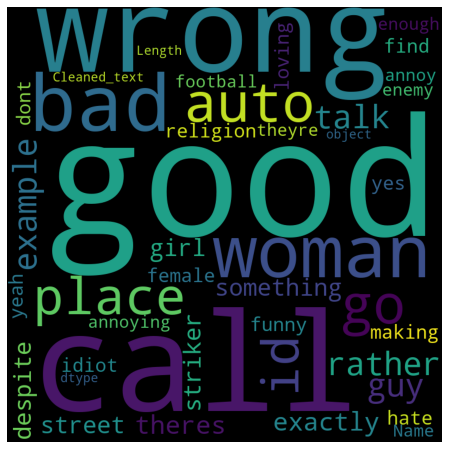

In [419]:
wc = str(df[df['oh_label']==1]['Cleaned_text'])

wordcloud = WordCloud(width =800,height=800,background_color='black',min_font_size=10).generate(wc)

plt.figure(figsize = (8,8),facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Word cloud for negative class

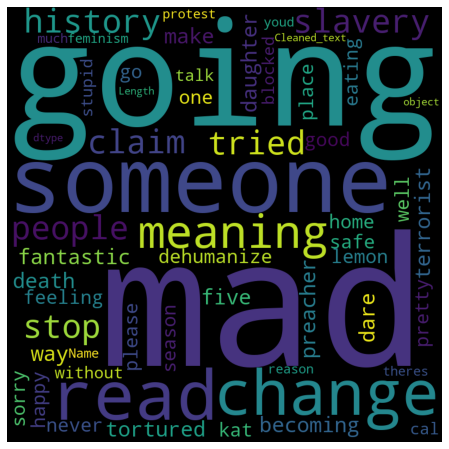

In [420]:
wc = str(df[df['oh_label']==0]['Cleaned_text'])

wordcloud = WordCloud(width =800,height=800,background_color='black',min_font_size=10).generate(wc)

plt.figure(figsize = (8,8),facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## word2vec  - skipgram

In [688]:
df

Cleaned_text  oh_label
0                    read change meaning history slavery       0.0
1      claim people tried stop becoming terrorist mad...       0.0
2                  call go auto place id rather talk guy       1.0
3                                  wrong example exactly       1.0
4                  preacher tortured five daughter death       0.0
...                                                  ...       ...
16052                  feeling sorry safe kat going home       0.0
16053          pretty good happy well never eating place       0.0
16054  lemon please go one season without someone cal...       0.0
16055                                stupid talk blocked       0.0
16056       protest mad theres much reason youd feminism       0.0

[16057 rows x 2 columns]

In [740]:
from gensim.models import Word2Vec
from gensim.models import FastText

In [741]:

x_tokens = [word_tokenize(word) for word in df['Cleaned_text'].values]

In [768]:
x_tokens

[['read', 'change', 'meaning', 'history', 'slavery'],
 ['claim',
  'people',
  'tried',
  'stop',
  'becoming',
  'terrorist',
  'made',
  'terrorist',
  'brain',
  'dead'],
 ['call', 'go', 'auto', 'place', 'id', 'rather', 'talk', 'guy'],
 ['wrong', 'example', 'exactly'],
 ['preacher', 'tortured', 'five', 'daughter', 'death'],
 ['bad'],
 ['going', 'make'],
 ['dare', 'fantastic', 'way', 'dehumanize', 'someone'],
 ['theres', 'something', 'wrong', 'girl', 'street', 'striker'],
 ['dont', 'run', 'blocking', 'manually'],
 ['good', 'good', 'despite', 'bad', 'religion'],
 ['help',
  'everyone',
  'pass',
  'judgment',
  'anyone',
  'comes',
  'looking',
  'help'],
 ['yeah',
  'human',
  'life',
  'idiot',
  'something',
  'genocidal',
  'wouldnt',
  'understand'],
 ['eventually',
  'like',
  'wait',
  'harper',
  'harper',
  'still',
  'dont',
  'know',
  'adjust'],
 ['delusion', 'factory', 'running', 'full', 'speed'],
 ['kat', 'river', 'chance', 'save', 'one', 'type', 'sandwich', 'would'],
 [

In [796]:
skipgram = Word2Vec(window = 3, min_count=1,sg=1)
print(skipgram)

Word2Vec(vocab=0, vector_size=100, alpha=0.025)


In [797]:
skipgram.build_vocab(x_tokens)

In [798]:
skipgram.train(x_tokens,total_examples=skipgram.corpus_count,epochs = 50)

(3868698, 4134250)

In [799]:
skipgram.save('models/skipgram100.bin')

In [800]:
len(skipgram.wv.index_to_key)

7560

In [801]:
skipgram.wv.key_to_index.keys()

dict_keys(['kat', 'like', 'dont', 'people', 'get', 'one', 'think', 'would', 'know', 'cant', 'go', 'want', 'time', 'good', 'really', 'going', 'see', 'men', 'make', 'even', 'oh', 'thats', 'never', 'need', 'call', 'way', 'still', 'right', 'well', 'say', 'hate', 'woman', 'much', 'back', 'got', 'female', 'doesnt', 'us', 'love', 'didnt', 'ever', 'stop', 'every', 'many', 'look', 'someone', 'thing', 'twitter', 'another', 'show', 'better', 'pretty', 'man', 'cook', 'yes', 'religion', 'bad', 'take', 'world', 'sure', 'read', 'nothing', 'could', 'actually', 'hope', 'cooking', 'colin', 'tell', 'yeah', 'give', 'day', 'prophet', 'talk', 'food', 'work', 'stupid', 'two', 'anyone', 'face', 'anything', 'use', 'made', 'please', 'round', 'sorry', 'theyre', 'believe', 'real', 'last', 'wrong', 'something', 'god', 'death', 'war', 'also', 'idea', 'find', 'must', 'next', 'said', 'try', 'new', 'always', 'watching', 'first', 'come', 'instant', 'tonight', 'girl', 'home', 'everyone', 'trying', 'ill', 'theres', 'maki

In [802]:
## take the mean average of the words in each twit
def document_vector(doc):
    # remove out of vocabulary words
    doc = [word for word in doc.split() if word in skipgram.wv.index_to_key]
    return np.mean(skipgram.wv[doc],axis=0)

In [803]:
X = []

In [804]:

for doc in tqdm(df['Cleaned_text'].values):    
    X.append(document_vector(doc))

  0%|                                                                              | 22/16057 [00:00<01:26, 184.65it/s]

read change meaning history slavery
claim people tried stop becoming terrorist made terrorist brain dead
call go auto place id rather talk guy
wrong example exactly
preacher tortured five daughter death
bad
going make
dare fantastic way dehumanize someone
theres something wrong girl street striker
dont run blocking manually
good good despite bad religion
help everyone pass judgment anyone comes looking help
yeah human life idiot something genocidal wouldnt understand
eventually like wait harper harper still dont know adjust
delusion factory running full speed
kat river chance save one type sandwich would
literally site today
juxtaposition
woo cant wait see
tend document hair color later pic old
according holly shore sassy halfway slut classy
vomit
looking forward ash camilla butting drama great
food poisoning
brain dead repeat said million times
think two facing sudden death
time channel reconsider association dangerous man
male time collect trash
dont believe certain
sell get men
sure

  1%|▍                                                                             | 81/16057 [00:00<00:59, 269.61it/s]

peace important freedom even important
oh another trip around country cooking shark show one maimed beyond recognition
want understand lie living peace read
yes
like lamb
priest captivity execute
real men superior
kat massive biggest ever
potato blowing mind duck fat figuratively dying bliss
kat oxygen
actually theyre mistake beyond comprehension rubbish geography
first photo mike brown innocence
anything female comedienne lot
feel like wonder woman
unlike hilariously ignorant cant spell racist sorry unfunny
kat one nasty bitch
total liar like prophet un dont burn people alive
show people slavery leftist moral stupid
since give science go sell wild
goal
kat oxygen
ash
favorite part trip amazing new
militia driven religion hatred bigotry freedom regardless
kat deserve get
proof comes true knew rig draft could get seth
stay go
real
learned
world ever produced anything would support
world live
doesnt answer anything answer illogical delusional superstition
look announce final score reveal

  1%|▊                                                                            | 177/16057 [00:00<00:40, 393.96it/s]

come hit child abuse
mad maybe instead calling crazy dramatic ask
glad annoying blonde got
bingo complete alone
maybe still right
happen clear better food seriously
people disagreed married year old
point id happy wrecking random havent done
sorry gruesome
thought one top high easily see
salon salon shut free speech shut people race card
everyone jealous coffee maker love pure
teenage let people read see comes hate
keep saying pretty
hate kat cooking competition stop voting strategically soggy
didnt overturn either place people people right long elect new
sick kat scraping teeth kick show
made genocide slavery wrote obituary
call crazy like food wouldnt pay build dessert
happy watch last episode
must
would vote make sure kat go home know strategic voting
joke theres value voting anyway drag apathetic please need high turnout
searching name people talk thats bit
true corrupt beginning
thing done lot guessing
man afraid commit woman really divorce ruin life
wish went death row instead su

  2%|█▋                                                                           | 353/16057 [00:00<00:25, 607.78it/s]


feminism use young dirty job
notice didnt see kat cut
get fantasy
turning pair kat desperate strategic scoring
exam
rule apple adapter never able find finally need
atrocious
fact example prophet letter
sure twitter within wow good idea
world starting see must living perpetual cloud disappointment
honestly activist perspective man try tell whats wrong
big lie doesnt advocate tolerance coexistence hatred murder
oh well
try get education repeat stupidity get imam
alima
summer
people work hard make world better place work hard book drink sex party
call sight smoking unpleasant
sovereignty real bestow sovereignty
kat cartoon develop sportsmanship grow take like man
remark necessary one
sure anyone kat arent say get boot pretty
welcome instant restaurant mean sassy
world wisdom make
next door still murder regularly
exact reason shouldnt involved like always blown
go foot front
adult least wine sorry truly suffer day
already propaganda many times
love little
understand meaning karma
spot rai

  4%|███▎                                                                        | 688/16057 [00:00<00:13, 1157.80it/s]


yes get rid kat
drunk duck fat vodka whatever
saying way life cannot democracy must instead follow
yeah fighting freedom democracy lite
situation tense eastern countryside
ugly fox news would taken
dont need men carry heavy cannot like shopping huge sense
literally domain
oh god real super fake tell fake
dont care idiot absurd opinion
sandwich maker added kitchen head quarters
promise woman going much lower threshold grown man
woman proper staring whilst parking car babe male therefore drive truth
support ghazi one safe many people harassment
except jihad
id love turn around tell lady shut way bossing husband around super
id happy read post view especially whether appropriate takedown th
love life
inventor old
anyone else notice based sausage cock
much closer democracy
sassy rubbish would eat
absolute truth verify anti propaganda
dedication
thought color
pretty sure reverse bus land female bus driver cant reverse property
kat ashamed dont deserve hope get next week
straight world read

  8%|█████▋                                                                     | 1219/16057 [00:01<00:07, 1899.47it/s]

military shipped
dont like wishing bad luck gosh really dislike kat much worse tennis man
music
thats hit sam made home safely really desperate
equal opportunity
filth hatred phony
crossed lemon curd catch fire
havent seen go killing rampage holocaust violence answer everything
frog voice back
another round instant get good stuff already
like seriously get one racist leadership position today
negative
drink wine heaven heaven basically drunken whore house spiritual
really hope kat fail spectacularly humiliating manner possible thoroughly horrible people
claim oh religion kill
nickname grandma
according habit fired
article person likely never read page
dont suck
still sellout still unacceptable disgusting
one got get dont install use default
sudden diabetic coma
blocked thought blocked someone else
erd wait disgusting act tattoo misogyny
mirror look like arses
finally good part
hope kat leave soon soon
making boy burrito
thought going win choice dish coz doesnt mean everyone else
say sa

  9%|██████▊                                                                    | 1448/16057 [00:01<00:07, 2015.56it/s]

really like twitter social communication
evil slightly lesser guess sort moral description
alima read code
snort
teenage dodge making assertion assertion zero evidence garbage
foul
exactly marketing ploy
like first game two linesman game always luck like
really hope bottom two kat
get upset stupid constantly say
make post contents talk
prophet used killing coward
cant think good period actually
upset cause youve got dick
anyone poor
embarrassed
hate kat
like kat
deray drawn
low doesnt give special insight atop pulpit privilege living shouldnt premium
wow must
razer chroma
dont seem understand could care less law
unless learn propaganda
lapidation amputation crucifixion
job stand nothing hereby away
keep incorrectly actually thats harsh sorry ladies biz
begun digging around fear aggressive assault stronghold
stand beside know truth savagery
never stopped stopped immoral
love chestnut creamy caramel food
obviously without shred evidence meat conspiracy theory
thats greatly going financia

 10%|███████▊                                                                   | 1671/16057 [00:01<00:07, 1888.01it/s]


watching dont know life last one best yet
theres platform could easily collapse
nothing ever perfect good start towards fixing huge percentage harassment
jihad two
possibly go personal
thought pull back
need talk official uniform
must watch share
read god
religion honest woman victim
even real person men superior
oh well chance winning anyway good luck
idea already thing like arent console
put man jail never even sex lied club
basic sociological like stereotype threat
bush answer
oh beating heart
rainy day sleeping baby hot coffee last nights hubby work early
add confirming didnt go home really channel
feel like watching kat poppin head like pug
hen party almost pete going jump cake
get attention tweet thats
ice cream machine possible
wrong
murderer rapist slave trader bigot caravan robber liar imperialist
energy run account least take time muster halfway witty response
someone please wrong face buried coffee cup
timely philosopher given birth needs reform
never someone laugh much eh 

 13%|█████████▌                                                                 | 2038/16057 [00:01<00:08, 1638.59it/s]

like rush public get much intense oh boy
ever period shut
twitter really optimal long
genocide denier didnt realize talking lunatic left fringe nice day
kat one thats done simply evil worthy show
hungry move competition kill eat last standing win
karma kat
see point supreme wait
strategically kat cant cook
saying something stereotype stereotyping
awesome dont know write truth feminism
really didnt mean dig anyone horrible way thought bit snow honestly
good impose sick rule
weve flee dont fight morale decline
fact person yo hear
smashing nailing needs come board sponsor challenge
cooking cooking competition
great choice call dont like video unless survival
show example
meet class elegance humility
rape violent crime
put press today back frantically cleaning time haircut
face excuse self righteous son bitch oh dont worry wasnt mo
sudden death actually literal live diet see first
trying play still respect doesnt admitted selling
wind going avoid
amazing love
like lemon
golden age regularl

 15%|███████████▎                                                               | 2423/16057 [00:01<00:08, 1665.05it/s]

cos thats suck get
woman via telegraph
stupid understand century barbarity would bring
wow wasnt stiff witty banter real
let men thought wouldnt disappoint crucial moment
dont attitude turning everyone
two even thought way round arent surprising
contrary brutal bigoted god abuse
use wasnt get responsibility free card movement
keyboard go anyways go either way
headed keynote state harassment
oh damn got working
dont believe think money attention
possible reward rename name choose week
met male writer pub trivia insufferable kept marking wrong without team input joke answer
sure yeah bail pretty quickly city day
look world stuck
speak go dont get choose
kat needs kick
kat suck hope get soon
ladies dont think cant drive know cant park back parking space
atoxic need
rose josh great
wow
seriously many instant restaurant year
crackling stop pretentious calling crackle
oh new judge alert
nice fag part mythology making female retarded try car
prophet room call anyone since religion hate bigotr

 19%|█████████████▉                                                             | 2996/16057 [00:02<00:06, 2176.36it/s]

maple bacon go wrong
offended grammar
dev never forgotten put sleep increment wrote poorly designed loop please stand
order vacate bases move coalition
dont think wont go dont put cape unless plan hero photo job
oh gosh problem traveling forgot garrison stuff
yeah something mounted directly desk get move furniture sometimes
painting inhuman exactly
kim un
used
maybe teach respect like
think tony might trouble scrape
even kat gave still would still gone home
cant stand kat
based based kat
kat fair hypocrite
like torture defend doesnt seem convince
thank calling though probably made clear original
start came
rust everyone corporate greed one create altruistic
annoying house fire taunting
stay cover sure
hey try
crossed
mad stop
love stuff different night
cooking potatoes head
think two facing sudden death
bey wearing wonder woman video blow
morning would problem
sooner later liberal must fight back
one consider actually get tax less intensive even
talented
justice language framing big pa

 20%|███████████████▎                                                           | 3272/16057 [00:02<00:05, 2335.05it/s]

unless get professional agree
stick censorship sun doesnt shine
budget tiny got big expense
yes call whatever seriously think terrible driving chromosome
personal like wanting work tech without
never resistance oppression always source oppression non believer
hatred
fair activity commit bit
message clear target left completely isolated torture terrorize abuse impunity
criminal ass sell
saw follow row really due damn
guess stay south go
crime cooking shade
dog better mine well even eats
growing religion breeding religion
ill believe feminism equality start demanding death wont hold breath
suspect doesnt know either connection site posting
backdoor communism
eaten army food better less like dick
indeed although police fairly nice
sadly answer best way go
look fancy place plus got facial bright hair personal style
salmon hollandaise dish mind hair feel way
given declared war humanity ago burn
like let cat keyboard
taking picture smile ill cut head
hate watching play sports
didnt make cont

 24%|█████████████████▉                                                         | 3833/16057 [00:02<00:05, 2249.22it/s]

thought going score dessert
hey voice man top seriously taking piss eh
like razor hand oh wait
sake sort disgusting blush enough enough
approve prophet raping year old girl like
thats tweet work ways
say one time
forgotten incessant use word mate
know know intent prove dont know
weet prophet
endless instant restaurant making develop every time touch whisk
hell redemption round season
ladies gentle men parliament
another stupid move bring action help kill brains fried
people
know religion pure evil
salon feminist tactic claim oppression worse group
really dont like
oh anyone true female funny one ever
someone recommend good book
dump leaving nothing saying three times divorce barbaric
freedom real democracy
classy elegant one way
doesnt control simply unrealistic conspiracy theory
count many wasnt sure confused
racist tired
proof anyone find love nexus learn
try defend prophet never tell proof
breakfast food get best mornings
dont doubt life realistically dont think well see evidence do

taking anyone without consent nice strawman tho would trash
giving talk
use propaganda
furthermore last give slavery many pressure west
call whatever theres big difference equality ability general
unfortunately sausage little bit short
holding one finger sign
good community wandering one going get people talking
continually tell winner avoid constructive feedback
dont right mean unless becoming
wait back shot kitchen wearing blue knickers honey
filthy liar abuse clearer
gloating
kat voting tonight absolutely rubbish
oh lord filing false report supposed false
horrible human score even good cooking get
done show torturous id rather
happy hear
group rape murder racist well
mistake like could sympathetic
like post stuff respect
butcher never silly
rink going alright
wow huge football
sure problem controller driver game
would like defend first
nice truth
propaganda unarmed kind fight win
reason percentage fallen almost zero
ever develop lasting romantic anyone edition
dont relate social med

 25%|██████████████████▉                                                        | 4067/16057 [00:02<00:09, 1292.99it/s]

shut
lying bitch zero account feed
gave come
huge ego never produced anything everyone kind like twitter
kat two disgrace honest cooking whole way
need sit
kat scum going get joy
onto someone serving food miss
perturbed neighborhood strip club feminist people time
best part body simply make clean
provide need
get superhero swim
guess time learn racism
good night
agree every giant publish front page next seven days
thats original account
liar come student association web site
dislike weather
cannot stand watching sport question question question
look organic grass fed take back
us
lemon tart custard tart shell
go ignore reality keep spouting left wing dogma engage favorite flavor hate
certain talking
one
arent
new name another inane tool use silence logic
crap good oh thats right kitchen silly
show aint good
seem lovely
success
legitimate even works fine
real contribution world
call label old fashioned theres sight world drunk woman hell
look towel wrapped around head pretty freaky
woul

 29%|█████████████████████▌                                                     | 4625/16057 [00:03<00:06, 1774.95it/s]

great new ash camilla morning
worse may
good lord done fool
thought odd annual event read
love legit could end argument posting armpit hair
dessert oh colin colin colin sigh
first two stole property
skin hair proper ladies literal
adorable
hey met
marketing general tech would love read
sorry cannot stand burke awful
percentage usually poor marry man nothing persuasive
dont think thats quite dead mum
di
cant even
read masha book man without face sense action
josh mum right combination extra bacon request perfect touch well done people like free
sometimes bot comes undesirable
wouldnt concerned outside canon historical evidence
oh god oh god oh god never point microscope skin
let know say see today calling police sorry
regardless land rest
chanting martyr blood vain lots talk
breakfast
texture different matte kind like concerned dropping one get case
house
ever get know freedom half free
survivor immunity
disaster sa
kat shame integrity cant even pretend gracious
telling dont help person

 33%|████████████████████████▊                                                  | 5301/16057 [00:03<00:04, 2426.52it/s]


people need stop breaking al information already old wrong everything fine al
kat shut let go tool
dog
one accused drug wife best labor
go home already
elite army fail company
game
seriously twitter system death atrocious ineffective please fix
probably would dont want deal cost hotel
us didnt launch proxy war
patriarchy myth system push back use chivalry benevolent masterfully
one fighting fighting freedom democracy fighting
go
alima slavery prophet slave owner trader
people mean men clearly
religion accommodate cancerous
patriarchy expel divulge note saved copy paste like
remember dude led mob many never another
officially hate kat hope karma hard
kat horrible people deserve still competition
work
quite symbiotic relationship
hey tech industry need talk someone yeah good
declared war humanity ago nothing
suggest idiot
dont marry time
blue mixed touch purple make fade gorgeous clear swear
kat strategic reap sow oh getting bonus cook good food problem
think end rank best cant cheat
kn

 37%|███████████████████████████▌                                               | 5897/16057 [00:03<00:03, 2671.09it/s]

aside security one time cage door fell head
really one screw lose
didnt realize supposed treat child whose opinion irrelevant sorry bad
atrocious script racist boring
die bacon cry
use word whore regardless gender refer
ea getting closer sizes
want hear female call game
people forced make strong female char
half half spearhead
yeah break democracy trying exterminate smart
vegetarian extent eat anything beef extent female
thank making one tweet longer
behind counter
woman stand unless name funny
know exactly truth apparently dont
return rebuild tell alone
first challenge
man fraud trying convince religion hatred something different
fan dont like industry good
oh look back
theyre hot generally view
yes make look home grown
lots classic love wod
people dont like theyre reality show irony
theres good talk section page bad didnt make main article
lamb breakfast
picture answer lost
truth smart woman men dont want handle
one less think still role keeping normal persona
loose
back thought exce

 39%|█████████████████████████████▏                                             | 6256/16057 [00:03<00:03, 2922.28it/s]

liar submission peace
protest march
pothead sweetheart might kill one time living room sleeping
half
serving
appreciate every donation received threaten pull dont say want hear
slave trader
cat almost level ai still alpha
since people apparently suffer
regard threat problem
slam lying propaganda want know filth hatred read
marinated gater
tempting weird money still feel kind patron blame mentality
stupid make watch stamping someone
suit
band outside apartment
work job wage works formula would show gap
like tank girl water power run white wait
wouldnt nice sudden death kat
people even talk white privilege majority food stamp white people
dont ten listen bad chanting give verse number make point
love beehive
talk visiting sick neighbor idiot
call old feel woman needs know throw kitchen man
walk one foot front really amazing advice holy crap thats
cant believe blonde made sausage like feces
everybody kat shut
telling leave house
hate female
first ever man woman fight taking place weekend 

 41%|██████████████████████████████▋                                            | 6566/16057 [00:04<00:08, 1171.27it/s]

free speech threaten innocent man question narrative shut
er single model mean multiple whatever
sold got us
time go hat
ash back
crazy wasabi red bean
giving talk going
may kat far everyone else
dont understand simple technical definition giving much problem seem think excessive
think want isolate right
slave trader caravan robber murderer beheader rapist bigot liar like
proof
main
officially hate kat thats like cheating strategic really heartless
red ranger female right red ranger always guy
taken church born never subject
oh mean like competitive lipstick application shopping world series eyelash batting
officially lost respect collin left
yes hate religion hate
really put ass
tell gaming convention thinking dress boots
sorry kind place vent like really
seriously trolling one legitimate resident
quite fan leaning operate cost high everyone feminism
oh go center beat mentally speak convert
many delicious breakfast would seriously struggle pick one
didnt ask time opinion
one damn thin

 44%|████████████████████████████████▉                                          | 7046/16057 [00:04<00:06, 1490.54it/s]

right leaving religion telling
oh good include targeted air
tell
going tweet domestic abuse funny
candied pete love dont
woman cant stop talking
come counting
horrific week long repeated gang rape
need post keep article going
ah dont sit think ranting
end going run away go witness protection
breed like kill non force religion people sword
happy
gag
apple
goes around comes around kat shut
dont make laugh like whip something entertaining
saw working directly safety department faith want right thing
people keep stuff posted site dun dun
prove us provided group bigoted
new reason people hate shove
look raw think
yeah little fuzzy cant reach would never ride behind chick motorcycle
also phone tell ya hit perfect change make fit
uplay launcher repeatedly
wow cant help feel
oh kat weve embarrassed ever since show
someone smash bottle rose lime cordial head please
know husband control
worked fine first playtime keep would work another sec
man without trying cant even create explicitly
cant ima

 47%|███████████████████████████████████▍                                       | 7600/16057 [00:04<00:04, 1833.49it/s]

standard operating procedure paint bullying authority
great support right financial abortion cool
lying older already fortune met hired
pretty sure white men make everyone else unemployment yr action program still working
honestly
catching kat disgraceful wish gone
initially lived vast majority live
like stool chart one plate
leave city use human shield defence
forever cant park fact
think hot hope use twitter inevitable trial
sports worst thing whats ever sky sports news
raw egg
want add blackmail tape time use
watching rail doubting
petition call attention judge
theres woman comes go running back door
actually ash tonight though always like hair back tight
time weakness could capitalize take turf
please explain figure wage gap thanks
think someone cant get laid abusive
go read pact dont waste time
mean like good luck razor sharp enough shave hirsute
sure wed like eat breakfast anything like
goes ways limited sample size people far less likely harass
killing idiot
find endlessly repea

 50%|█████████████████████████████████████▊                                     | 8102/16057 [00:04<00:03, 2010.66it/s]

know feel
slow clap ladies inception
holy awful
legal advice common sense help people know say police help find lawyer
best part style precision cut scream hair randomly
oh colin room
anti fine anti offense
must say twitter useless dealing harassment block report tell wont
clip listen listen listen
great use right great
know find people stand fire
season going finish decade drag
rampant misandry feminism perhaps antifeminism
commander abu sniper today
explain would
use team name
sandwich press office mess tomorrow
call whatever met arent cut working full time
twitter web hearthstone
liar lived third class legal right
nothing truth
anyone compromise power people absolutist delusional
human group contradiction
cant imagine
felt need express reason dont get wrong seeing female site weird
good established humanity evolve past slave
seriously person caught belief person morning news
like rubbery cardboard bit like leathery skin pete
voting strategically well
sure hungry
dont give cheese
pon

 54%|████████████████████████████████████████▎                                  | 8628/16057 [00:05<00:03, 2253.78it/s]


youd think shred truth would void
make inane speech religious tolerance avoid facing problem
must found imagination doesnt exist
idiot bad ignore barbarity
liar trying change subject hide proven fact prophet
doesnt want take world like
yes given one group routinely twitter along id say worse
say dont hate dumb saying dont hate
hot hot average
oh use real
nice know made mad
unlike cant wait see crash burn
well hello nice see ill taking home
lie
religious freedom freedom must
really hard wear press release going change everything
ill add doc understand art likely take us get right
none true return original read
mention crushing poverty endless violence legal forced marriage year old
one ask serving propaganda swine
well cab days time guess dont eat drink ca
boring drive ever
police beat woman veiled clothing living
abuse comes days old
go sassy made apple pie
hope win
busy day
ever idea comes
hate
strategy kick ass strategy cook food
original content
turn heat competition think store
er

 58%|███████████████████████████████████████████▏                               | 9251/16057 [00:05<00:02, 2541.86it/s]

disappointed strategic scoring
stupidity try force us tolerate intolerant
obviously natural
determined arent worth effort deal
terrorist
living ground like appropriate
kat disgrace booted score low save
feel like producer step stop people
another bloody instant restaurant week seriously shark riding two powered sh
pathetic channel
ion know id react son came throw football head
opinion blocked twitter probably fairly predictable
strategic scoring wrong secret ballot way go reveal end
female analyst
either stop making
thing thing
whats face like varnished
like pow
female bartender agree certain gender
people behead honor killing want exterminate could care
sex slavery permitted many proof
colin fully channeling tonight
oh kat forgot
would really funny surprise wouldnt
would think last many would learn cook something easy yummy
seriously japan need talk
people reply get
yeah talk send right told retracted
fiddle dee dee
wouldnt depend
long winding story
definitely female thats going oh wa

 62%|██████████████████████████████████████████████▌                            | 9982/16057 [00:05<00:02, 2967.26it/s]

really hope get
spatchcock strut time
kitchen challenge ash camilla win choice
look face like shut pete
forever
riley hilarious stern thought
think randomly tweet
library
awesome love
opinion football man thing
would awesome
theres real technique blonde chuck together hope best
many family camp site
volume talking
floss weekly open source paying
hey kat gloat pretty colour wear love look oh thats normal face mistake
awkward
easily confused wouldnt thought
think us would love give heavy worry relationship government
watched morning news twice past week could
unreal give jordan target
also read gay slur
outside conflict still honor
go cash manilla
read story behind verse
difficult conversation process trigger warning
brought dont like either everyone needs stop calling fat
really loose nowadays
book doesnt exist thats pretty weak
rating constantly helping friend gear
tried help humanitarian aid much
least partner like guy weird feminist counterpart seeing
dont ever want female talking fo

 64%|███████████████████████████████████████████████▍                          | 10291/16057 [00:05<00:02, 2598.59it/s]


big deal spell checker times look like twat making issue
get didnt good job stop blaming strategic voting
record prove wrong female ill make formal apology wo
double elimination
least might future new ben offal marrow
thing
kat looking smug cant even cook
gave unfortunately less
taking piss two surely
whats
canada us fathered man
display nice sure battery life tiny bit responsive sure wishing faster
complain chlorine gas thats rich send die
seriously colin stop frowning better
cant wait see kat royally stuff already starting twitch
one must imagine god hateful war mongering decisive bigoted religion calling
like somebody juggling wont take responsibility one onlooker
holocaust scum million mil
thanks bing
claim puppy police happy
science good men cant monogamous
sorry dont believe version justice mass dealing anything
editorial murderous soul radical foundation western civilization
id space people already booked
alive stop preaching religion focus like jordan
advert really happen
kat 

 68%|██████████████████████████████████████████████████▍                       | 10939/16057 [00:05<00:01, 2758.94it/s]


media tod state burned burning
behind counter see stuff like small pharmacy
flood wont see legitimate harassment come
understand religion dont
operating terrorist mandate conquer world violence
entirely accurate run bin find committer recent
spent three trying figure level
angry like undead supposed fist air slapping butt
sorry call shouldnt get involved football made oath never take bird lan
everything back road
men assume angry otherwise might admit
call holding conversation football possibly painful experience life
would irony name way irony
ie still feel way
social justice type shield behind fashionably racist snicker self
kat serving dessert
theres nothing sassy hot pot
nope didnt blocked thanks know
kind left several gulf
south operation
male action female action
yes science advance past superstition
female goal female sport even thing
love good generalization entire nation people
religious war
consideration extraction strategy attack weak hardly noticeable
vile actually feel so

 70%|███████████████████████████████████████████████████▋                      | 11225/16057 [00:06<00:01, 2601.66it/s]


poor colin looking best
hopefully didnt badly oddly enough pointed well said
calm joke
slavery rape practiced slavery rape
another lie bad seed show extremism
lecture older people insulting pearl code
tripple price
music personally prefer men seem passion
terrorist group election usual one man one vote one time election
god kat awful awful person oh good
awesome
yes sit let murder enslave
certain pete spittoon food taste
bad precedent
house situation weird tho walking across park get front door
also guy posted home address twitter
nobody said anything racist talking
culture real issue like fought way strong cant problem
brotherhood linked brother us
fact behead
really must read long form essay
white need deny privilege act like none
get hell sort
yo going going could cause trouble
see pretty think quite ugly making theyll go think tony
today example produce nothing steal extort live murder hatred
dont know nothing treaty
find people claim dont know anything dont know anything
made pas

 72%|████████████████████████████████████████████████████▉                     | 11494/16057 [00:06<00:02, 1882.71it/s]

feel like
another ad seriously
hope amazing main course
understand score wack
point way going know dead end
might eat great feedback ham dish
thats plate still though find like yard
kitchen episode recap serve record
revenge thought confused ugh
book violent fairy tales
shouldnt keep people cooking competition focus people actually cook
needs give million guess
elegant beautiful like us
thats year old man year old girl like
dude dude episode point might break
four say something substance blocked
bad
think adequate dont want go
losing mum dad well dont cry lost batman
absolutely ignorant
know teach hate teach nothing run country economy
get know social data
thats like saying freedom limited kill
sassy mean right
cardboard thats food
doesnt stop health congress
got temp mass twitter
thats works private account
sure really shouldnt
year old woman cant find right goes honeymoon stop
slapping would ur walk
smart wealthy man tortious course
extremely unlikely entire female population rape
se

 75%|███████████████████████████████████████████████████████▌                  | 12063/16057 [00:06<00:01, 2270.08it/s]


participate shave legal aint guy want hairy
coz one else
ice cream broken got middle bit turned upside
wonder
bring
feel guilty scary true tech
gee opinion zero evidence convinced
going become tell
may seem far reach lot people us also far removed class would impact
brain would ashamed
forget lemon tart
judge cage
nobody stupid simple going kill hope one em
every
direct quote comes learning prefer male nice try
face kat hideous
rarely stop
oh good lord kind patience
literally photo evidence
awesome go daily use folder
hardware hacking even writing
weird still learning ropes assume everything going difficult
curious might different new female
making feel right sassy
unbiased totally male opinion alert swear female funny
bitch walking around stroller dog dog doesnt need star
host nobody admit based honest
something notable besides give birth ill give deserve
colin working pretty crap id say
got article
purposely pick slightly unattractive whore besotted good television
already setting t

 78%|██████████████████████████████████████████████████████████                | 12601/16057 [00:06<00:01, 2413.19it/s]

furthermore age classified meaning sound
see piles dead
mike troll working propaganda sweat shop st
go see dress walking talk directly sea never
lovely sentiment imam
blinded hatred would feel tao blinded stupidity
educated professional
call think seriously knowledge comes feminism random
cut main road afar disrupt supply chain
theres multitude know turn hideous bunch
finally got peace plan proposal
three low score good work sherlock
quietly helping already
probably mix sort shelter
like mine
thats reality people regular peace loving dealt
yes violation rather burned
working together destroy
gave chilling weed walk door completely
learn
poor cant rape torture make execution video
could possibly
western media mass mass
literally cannot stand kat
however twitter web supposed thats doesnt really encourage party
laughing ass original tweet said shouldnt drive
take moment reflect everything wrong paragraph
kat
new dress
look land occupation green domination
woman tech speak
well son youve s

 82%|████████████████████████████████████████████████████████████▍             | 13127/16057 [00:06<00:01, 2508.94it/s]


dont call cause farthest holy hate feminine
judge whatever name needs stop fake tan literally orange
like weve got happening weve got better
call wouldnt mind stay home wife dont need raised someone family
tonight restaurant trashy
maybe people saying school system failing school system failing
back awesome cant wait see going year
men times
another dumb article writer find loss silly
call take serious theyre angry grandma
good obviously trying create confrontation
said burnt building left primary export end
spotlight barbarity create barbarity simply letter
seen one sure find context around
fact canon doesnt make better stay away
best way win cook well said far excellent reprimand towards kat
sewer cant express hatred throw sewer
phony die thousand away
think colin might fan
genuinely hate worthy individual goblin kat
probably
bomb laden vehicle today morning least today
broken ladies younger fail description one way another men feminine
shaikh bin air force squadron jordan fight
oh 

 85%|███████████████████████████████████████████████████████████████           | 13696/16057 [00:07<00:00, 2387.23it/s]

arm civil war inevitable
cannot stop watching blame
give less giving opinion dont like
world thinking breakfast dish bad
pretty blonde keep talking
exactly like female seen say dumb
dont overthink stick cool whip banana
us separation church state time us far today
bitch kat
need try reconnect tal afar fail enough men
sweat
want slap smirk face know know stand line
justice punish taught murder like murder
yes suck basketball unconventional sentiment begin
kat scored strategically stay bloody competition unfair
cant decide dislike dislike kat either way one gone tonight winning
obviously driving world domination force intimidation persuasion
awful tony creosote meaning life
dont phone get also twitter
youve got follow
evidence idiotic theory unnamed
enjoy cooking watch feral human behaviour go
would care opinion guy prophet
buy like lady comes make whiny teens shrivel die
political worried result innocent people pa
really tough problem big problem far reaching many different
verge major 

 87%|████████████████████████████████████████████████████████████████▎         | 13944/16057 [00:07<00:00, 2265.55it/s]

something flag raised unknown
really curious someone would try sell crystal
unapologetic furtherer abusive neo ex
much didnt like first episode begun hate kat much last week
manual filter
sadly apartment complex
saying anti feminist anti like saying anti anti
sorry say real begun gumption
backed straight thats would scientific precision
also used book account criticism sent personal blamed intern
show
maybe give talk year old year old
chemical fired hit chemical
sock trollop dont enabler dont need
kat wont survive next anyway
show dont start making
favor read
social media like social media arent real
guy body basic human decency deep capacity
well thats kat deserve get want
dude kind scary overly one us didnt pay certain amount every month
state resupply route extended take road
difference prophet
please nobody make elephant comment fat classy hate dress size
prophet made living robbing course make money stealing
treatment nearly bad people book outright
liar trying shut people term ra

 90%|██████████████████████████████████████████████████████████████████▊       | 14492/16057 [00:07<00:00, 2438.89it/s]

explain doctor optional surgery cant happen next time recuperate
karma karma karma
fear
breaking church five belonging near church east
agree spot early right
seriously got pretty sassy
whoa got camera taken evidence
cant even find describe much value work people met time much love
dont touch food feminist mantra
use baby practice population imperialism
catching society two pretty really hope
yeah kat wouldnt laugh hard brought back earth laughing
would
liar men
kat awful giving
half built west staffed gulf looking
ill likely back conference season
first fought also prison
dont mind looking collin whole season
liar ignore context truth
wasnt strategic voting kat food truly awful
wouldnt fair stay kat
kat better hope everyone eats quickly due back delusional town
werent said seen better oh
yummy make stressful
please stay please commit man commit gym well
lawyer unrelated police
didnt know working
say
anyone else punch head
cant filter exception
scientist researcher stuff write put soci

 92%|███████████████████████████████████████████████████████████████████▉      | 14742/16057 [00:07<00:00, 1880.74it/s]


one dont know
relief theyre lucky mistake
men like cut
theres huge lie everything sword point
logging wait
sure
sorry
told yell fire instead rape people would likely respond
like would hilarious didnt need help bad
stay home thing
tremble
work hard study hard get caravan robber lazy work
ongoing tragedy found learned work together support encourage amazing
wasnt bad
reason peace power
give sex jihad via
bet half aint even watching football see everyone
want play marbles go see
wow top shelf humor whats point cleaning lady sister
much dislike dessert look good
tomorrow
peach tea lavender honey complete
feeling going
know agree slut shame make valuable
actually sure last episode keep breaking song dance catwalk walk
another puppy
thought might like one
lemon tart bloody lazy incompetent properly
know obvious lie solution would scary mean
transportation country needs solution
hand message used concerned image
may business dont pretend anything backwards dictatorship
lost glory aware cont

 94%|█████████████████████████████████████████████████████████████████████▍    | 15058/16057 [00:07<00:00, 2174.60it/s]

difficult choose two despicable behaviour much bah
cant wait till get locked afraid hit girl fact plan
cant listen female sports
lot people would like put kat sudden death
call truth psychology male ego biggest hurdle crying still boy rest
sorry channel next top model
stupid woman
theme instant restaurant dream narcissism kitchen
last thing read football cricket sky sports news
man men cattle point
abortion convenient point
concentrate half half wise female commentator
goes theres going trouble
dont rely single case read pact
true see last
didnt talk getting
suck dick pinky air classy
go team hope win
call know arent stupid way another dont listen
trying defend murderous trying wipe un mean nothing
werent said
someone chicken liver blended baby food right
plan exterminate secret except maybe administration
dont know buy find hearty handshake two awkward
didnt realize
satisfied raping year old girl holy prophet also sleeping around
look nice
interest beyond example
pete
think theres rea

 98%|████████████████████████████████████████████████████████████████████████▍ | 15708/16057 [00:08<00:00, 2234.60it/s]

like role instance people play
rad upkeep
stand strong comfort give right one really listening particular group anyways
call sports reporter cant listen even think information credible
got worst think easier light
time saddle
else running afoul
taking life advice someone doesnt know wear ware
backwards
ea lucky enough find mine swap sell normal price see
need better ground stuff like shouldnt happen air got
something seriously must
achieve peace tried get see better light
tell woman wait tick
dont follow religion
refusing deal passenger
one said
use human anyone paying attention
sucking math logic requirement feminism
behead street magician entertaining insult
fate
stupid sister hell spoiled girl work struggle day
stoic night
come go start afraid
die kat
look weird
cant help cringe talk football
didnt serve cold pizza breakfast item
love save
agreed sure
see fact get way far often see fact
need go intercept ya know saying
calling kat people bit stretch person clearly still tony abbot
s

100%|██████████████████████████████████████████████████████████████████████████| 16057/16057 [00:08<00:00, 1955.13it/s]


learn logic
thank goodness
woke nap
thats awesome name
burned
see male row dont find funny attribute gender
hard say naively fun realizing anvil believe fun key later monogamy
dont faith tweet incoherent
also wrote
double standard
lemon tart plate crushed biscuit
kat suck deserve go home
racism
like boy yet washing still got
seen theyre linking harassment hilarious
sweetie threatening financial bullying backbone
watching sorry sound moment even bottom didnt make worth
weird address account sure need add
men discussion argue
kat maybe shelve towards get
thanks everyone sometimes stuff shouldnt small enjoying cute animal
marine pen russia today start war little green
runway put together
mitt needs run time cant run country
feel weird quick little like like lazy bad think conversation needs
next close grandma insane
zero far even funny
little short point us ignorant via
seeing philosophy regulation general think pretty disappointing leader
got directly
kitchen like cup
genocide last cent

In [808]:
X = np.array(X)

In [810]:
X.shape

(16057, 100)

In [811]:
def split_data(X,y):
    return (train_test_split(X,y, test_size=0.2,stratify=y,random_state=42))
X_train,X_test,y_train,y_test = split_data(X,y)

In [812]:
def train_accuracy(model,X_train,y_train):    
    train_pred = model.predict(X_train)
    return accuracy_score(y_train,train_pred)

In [813]:
def test_accuracy(model,X_test,y_test):
    test_pred = model.predict(X_test)
    return accuracy_score(y_test,test_pred)

## Logistic Regression

In [828]:
LR = LogisticRegression()
LR.fit(X_train,y_train)

LogisticRegression()

In [829]:
train_accuracy(LR,X_train,y_train)

0.7335149863760217

In [830]:
test_accuracy(LR,X_test,y_test)

0.7282067247820673

In [831]:
confusion_matrix(y_train,LR.predict(X_train))

array([[7839,  801],
       [2622, 1583]], dtype=int64)

In [832]:
f1_score(y_train,LR.predict(X_train))

0.4804977993625739

In [833]:
precision_score(y_train,LR.predict(X_train))

0.6640100671140939

In [ ]:
pickle.dump(LR,open('models/LR_W2V.p', 'wb'))


## GaussianNB

In [834]:
GB = GaussianNB()
GB.fit(X_train,y_train)

GaussianNB()

In [837]:
print("train acc = ", train_accuracy(GB,X_train,y_train))
print("test acc = ", test_accuracy(GB,X_test,y_test))

train acc =  0.6193849746983262
test acc =  0.6024283935242839


In [845]:
confusion_matrix(y_train,GB.predict(X_train))

array([[5036, 3604],
       [1285, 2920]], dtype=int64)

In [846]:
f1_score(y_train,GB.predict(X_train))

0.5443191350545252

In [847]:
precision_score(y_train,GB.predict(X_train))

0.4475781729000613

## Random Forest

In [843]:
RT = RandomForestClassifier(n_estimators=500)
RT.fit(X_train,y_train)

RandomForestClassifier(n_estimators=500)

In [848]:
print("train acc = ", train_accuracy(RT,X_train,y_train))
print("test acc = ", test_accuracy(RT,X_test,y_test))

train acc =  0.9898793304787855
test acc =  0.7387920298879203


In [849]:
confusion_matrix(y_train,RT.predict(X_train))

array([[8618,   22],
       [ 108, 4097]], dtype=int64)

In [850]:
f1_score(y_train,RT.predict(X_train))

0.9843825084094184

In [851]:
precision_score(y_train,RT.predict(X_train))

0.9946588977907259

In [853]:
pickle.dump(LR,open('models/RT_W2V.p', 'wb'))


In [735]:

pcaX = skipgram.wv[skipgram.wv.index_to_key]
P = PCA(n_components=2)
result = P.fit_transform(pcaX)

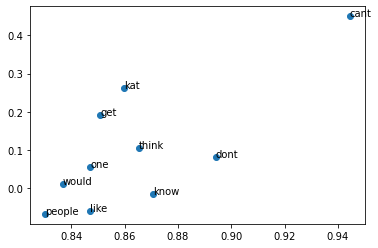

In [737]:
plt.scatter(result[:10,0],result[:10,1])
words = list(skipgram.wv.index_to_key)
for i , word in enumerate(words[:10]):
    plt.annotate(word,xy=(result[i,0],result[i,1]))
plt.show()

## Prediction on new data

In [854]:
## so far best on is n gram
twit_1 = """@scamp_faridxx @AbuAlbaraaSham Yeah, it's called caring about human life, idiot - something a genocidal Daesh would'nt understand. """ 
twit_2 = """ This home feels so good to stay and enjoying.!!!!"""

In [855]:
twit1 = clean_text(twit_1) ## clean test, with remove pantuations , lower
twit2 = clean_text(twit_2)

In [856]:
twit1

'yeah its about human life idiot something a genocidal wouldnt understand'

In [857]:
twit1 = remove_otherlanguage(twit1) ## remove other foriegn languages
twit2 = remove_otherlanguage(twit2)

In [858]:
twit1

'yeah its about human life idiot something a genocidal wouldnt understand'

In [859]:
twit1 = remove_stop_words(twit1) ## remove stop words
twit2 = remove_stop_words(twit2)

In [860]:
twit1

'yeah human life idiot something genocidal wouldnt understand'

In [861]:
twit2

'home good stay enjoying'

In [862]:
twit1 = lemma_clean_text(twit1) ## lemmetizer
twit2 = lemma_clean_text(twit2)

yeah human life idiot something genocidal wouldnt understand
yeah NN
human NN
life NN
idiot NN
something NN
genocidal NN
wouldnt NN
understand NN
home good stay enjoying
home NN
good JJ
stay NN
enjoying VBG


In [863]:
twit1

'yeah human life idiot something genocidal wouldnt understand'

In [864]:
twit2

'home good stay enjoy'

In [865]:
twit1 = remove_single_char(twit1) ## lemmetizer
twit2 = remove_single_char(twit2)

In [866]:
twit2

'home good stay enjoy'

In [655]:
## Load models

model = pickle.load(open('models/NB_tf.p','rb'))
vect = pickle.load(open('models/vect_NB_tfidf.p','rb'))


In [656]:
## Apply vector
X_test1 = vect.transform([twit1])
X_test2 = vect.transform([twit2])

In [659]:
X_test1.shape

(1, 7559)

In [660]:
model.predict_proba(X_test1)

array([[0.2760133, 0.7239867]])

In [661]:
model.predict(X_test1)

array([1.])

In [602]:
## IT predicted Positve

In [662]:
model.predict_proba(X_test2)

array([[0.83667959, 0.16332041]])

In [663]:
model.predict(X_test2)

array([0.])

## Although this model is predicting rightly, the f1 score is not high. we would need to train with different emeddings and algorithms